기본 세팅

In [1]:
from google.colab import drive
drive.mount('/gdrive')

!pip install konlpy
!pip install kss

Mounted at /gdrive
     |████████████████████████████████| 19.4MB 12.7MB/s 
     |████████████████████████████████| 460kB 60.3MB/s 
     |████████████████████████████████| 92kB 14.4MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 71kB 6.7MB/s 


Preprocessing

100%|██████████| 14290/14290 [00:41<00:00, 344.31it/s]


문장의 개수 : 14296
문장의 최대 길이 : 100
문장의 평균 길이 : 21.030707890318972


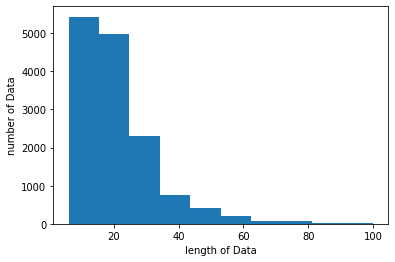

In [2]:
import pandas as pd
import re
from tqdm import tqdm
import kss
import matplotlib.pyplot as plt

df = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/blog text data.csv', encoding='cp949')
df = df.drop_duplicates()

A = []
for i in tqdm(range(len(df))):
    B = kss.split_sentences(df.iloc[i,3])
    for j in range(len(B)):
        B[j] = ' '.join(re.sub(r'[^0-9a-zA-Z가-힣]', ' ', str(B[j].strip())).split())
        if len(B[j]) >= 6 and len(B[j]) <= 100:
            A.append({'이름': df.iloc[i, 0], '날짜': df.iloc[i, 1], '제목': df.iloc[i, 2], '내용': B[j]})

data = pd.DataFrame(A)

data.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/blog text data.csv', encoding='cp949', index=False)

print('문장의 개수 :', len(data))
print('문장의 최대 길이 :', max(len(l) for l in data['내용']))
print('문장의 평균 길이 :', sum(map(len, data['내용'])) / len(data['내용']))

plt.hist([len(s) for s in data['내용']], bins=10)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

depression score model

In [3]:
import pandas as pd
import numpy as np
import kss
import re
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import sequence

def convert_to_ord(data):
    try:
        return [ord(xx) for xx in data]
    except:
        print(data)

df_blog = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/blog text data.csv', encoding="cp949")
df = []

model_yn = load_model('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/model_yn.h5')
model_09 = load_model('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/model_09.h5')

for i in tqdm(range(len(df_blog))):
    sentence_list = kss.split_sentences(df_blog.iloc[i,3])
    for j in range(len(sentence_list)):
        df.append({'이름':df_blog.iloc[i,0], '날짜':df_blog.iloc[i,1], '제목':df_blog.iloc[i,2], '내용':' '.join(re.sub(r'[^0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', ' ', str(sentence_list[j]).strip()).split()),'ord':np.nan,'label_1':np.nan,'label_2':np.nan})

df = pd.DataFrame(df)

df['ord'] = df['내용'].map(convert_to_ord)

max_len = 64

sentence_ord = sequence.pad_sequences(df['ord'], maxlen = max_len)
sentence_ord = np.array(sentence_ord).reshape((len(sentence_ord), max_len))

df['label_1'] = model_yn.predict_classes(sentence_ord)
df['label_2'] = model_09.predict_classes(sentence_ord)

df['label_2'][df['label_1']==0] = np.nan

df_yn = df.groupby(['이름','label_1']).count()
df_yn = df_yn.reset_index()
df_yn = df_yn.pivot(index='이름',columns='label_1',values='내용')
df_yn.columns = ['N','Y']
df_yn['all'] = df_yn['N']+df_yn['Y']
df_yn['p'] = df_yn['Y']/(df_yn['N']+df_yn['Y'])
df_yn = df_yn[['all','p','N','Y']]

df_09 = df.groupby(['이름','label_1','label_2']).count()
df_09 = df_09.reset_index()
df_09 = df_09.pivot(index='이름',columns='label_2',values='내용')
df_09.columns = ['0','1','2','3','4','5','6','7','8','9']

df_score_board = pd.merge(df_yn, df_09, on='이름', how='outer')

df_real_score = pd.read_excel('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/실험 참가자 명단.xlsx')

df_real_score = df_real_score.replace('없음', 0)
df_real_score = df_real_score.replace('2~6일', 1)
df_real_score = df_real_score.replace('7~12일', 2)
df_real_score = df_real_score.replace('거의 매일', 3)

df_real_score = df_real_score.iloc[:,[1,11,12,13,14,15,16,17,18,19,20,26]]

df_score_board = pd.merge(df_score_board, df_real_score, on='이름')
df_score_board['a'] = np.nan
df_score_board['b,c'] = np.nan
df_score_board = df_score_board.fillna(0)

df_score_board.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model.csv', encoding='cp949', index=False)

100%|██████████| 14296/14296 [00:41<00:00, 342.60it/s]
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
from sklearn.model_selection import train_test_split

df_score_board = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model.csv', encoding='cp949')

df_score_board_1 = df_score_board[df_score_board["그룹"]=="그룹 1"]
df_score_board_1_train, df_score_board_1_test = train_test_split(df_score_board_1, test_size=0.5)

df_score_board_2 = df_score_board[df_score_board["그룹"]=="그룹 2"]
df_score_board_2_train, df_score_board_2_test = train_test_split(df_score_board_2, test_size=0.5)

df_score_board_3 = df_score_board[df_score_board["그룹"]=="그룹 3"]
df_score_board_3_train, df_score_board_3_test = train_test_split(df_score_board_3, test_size=0.5)

df_score_board_4 = df_score_board[df_score_board["그룹"]=="그룹 4"]
df_score_board_4_train, df_score_board_4_test = train_test_split(df_score_board_4, test_size=0.5)

df_score_board_train = pd.concat([df_score_board_1_train,df_score_board_2_train,df_score_board_3_train,df_score_board_4_train])
df_score_board_test = pd.concat([df_score_board_1_test,df_score_board_2_test,df_score_board_3_test,df_score_board_4_test])

df_score_board_train.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_train.csv', encoding='cp949', index=False)
df_score_board_test.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_test.csv', encoding='cp949', index=False)

a

In [6]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

df_score_board_train = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_train.csv', encoding='cp949')
df_score_board_test = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_test.csv', encoding='cp949')
#df_score_board_train = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model.csv', encoding='cp949')

A_start = 0
A_end = 100
A_gap = 0.1
A = [np.arange(A_start,A_end,A_gap) for i in range(10)]
A[0] = 0

for i in range(1,10,1):
    for j in tqdm(range(len(A[i]))):
        real_score = df_score_board_train.iloc[:,14+i]
        pred_score = [3*math.tanh(A[i][j]*k) for k in df_score_board_train[str(i)]/df_score_board_train['all']]
        A[i][j] = mean_absolute_error(real_score, pred_score)

for i in range(1,10,1):
    print('a_'+str(i)+' : ', A_start + A_gap*list(A[i]).index(min(A[i])))
    print('a_'+str(i)+'_MAE : ',min(A[i]))
    A[i] = A_start + A_gap*list(A[i]).index(min(A[i]))

for i in range(len(df_score_board_train)):
    df_score_board_train.iloc[i,26] = 3*math.tanh(A[1]*df_score_board_train.iloc[i,6]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[2]*df_score_board_train.iloc[i,7]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[3]*df_score_board_train.iloc[i,8]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[4]*df_score_board_train.iloc[i,9]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[5]*df_score_board_train.iloc[i,10]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[6]*df_score_board_train.iloc[i,11]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[7]*df_score_board_train.iloc[i,12]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[8]*df_score_board_train.iloc[i,13]/df_score_board_train.iloc[i,1]) + 3*math.tanh(A[9]*df_score_board_train.iloc[i,14]/df_score_board_train.iloc[i,1])

for i in range(len(df_score_board_test)):
    df_score_board_test.iloc[i,26] = 3*math.tanh(A[1]*df_score_board_test.iloc[i,6]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[2]*df_score_board_test.iloc[i,7]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[3]*df_score_board_test.iloc[i,8]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[4]*df_score_board_test.iloc[i,9]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[5]*df_score_board_test.iloc[i,10]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[6]*df_score_board_test.iloc[i,11]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[7]*df_score_board_test.iloc[i,12]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[8]*df_score_board_test.iloc[i,13]/df_score_board_test.iloc[i,1]) + 3*math.tanh(A[9]*df_score_board_test.iloc[i,14]/df_score_board_test.iloc[i,1])

#df_score_board_train.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model.csv', encoding='cp949', index=False)
df_score_board_train.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_train.csv', encoding='cp949', index=False)
df_score_board_test.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_test.csv', encoding='cp949', index=False)

100%|██████████| 1000/1000 [00:00<00:00, 1840.94it/s]


a_1 :  9.8
a_1_MAE :  0.587163626940762
a_2 :  0.0
a_2_MAE :  0.8333333333333334
a_3 :  17.400000000000002
a_3_MAE :  0.8189417997168132
a_4 :  0.0
a_4_MAE :  0.6333333333333333
a_5 :  0.0
a_5_MAE :  0.13333333333333333
a_6 :  25.5
a_6_MAE :  1.0416067878029867
a_7 :  0.0
a_7_MAE :  0.7
a_8 :  0.0
a_8_MAE :  0.4
a_9 :  0.0
a_9_MAE :  0.16666666666666666


b,c

In [7]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error

df_score_board_train = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_train.csv', encoding='cp949')
df_score_board_test = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_test.csv', encoding='cp949')
#df_score_board_train = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model.csv', encoding='cp949')

B_start = 100
B_end = 1000
B_gap = 1

B = np.arange(B_start,B_end,B_gap)

C_start = 0
C_end = 50
C_gap = 1

C = np.arange(C_start,C_end,C_gap)

BC = []
MAE = []

for i in tqdm(range(len(B))):
    for j in range(len(C)):
        real_score = df_score_board_train.iloc[:,24]
        pred_score = 0.9*([3*math.tanh(k) for k in B[i]*df_score_board_train['0']/df_score_board_train['all']]+df_score_board_train['a'])*[math.tanh(l) for l in C[j]*df_score_board_train['p']]
        BC.append((B[i],C[j]))
        MAE.append(mean_absolute_error(real_score, pred_score))

BC = BC[MAE.index(min(MAE))]

print('b : ', BC[0])
print('c : ', BC[1])
print('MAE : ',min(MAE))

for i in range(len(df_score_board_train)):
    df_score_board_train.iloc[i,27] = 0.9*math.tanh(BC[1]*df_score_board_train.iloc[i,2])*(3*math.tanh(BC[0]*df_score_board_train.iloc[i,5]/df_score_board_train.iloc[i,1])+df_score_board_train.iloc[i,26])

for i in range(len(df_score_board_test)):
    df_score_board_test.iloc[i,27] = 0.9*math.tanh(BC[1]*df_score_board_test.iloc[i,2])*(3*math.tanh(BC[0]*df_score_board_test.iloc[i,5]/df_score_board_test.iloc[i,1])+df_score_board_test.iloc[i,26])

#df_score_board_train.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model.csv', encoding='cp949', index=False)
df_score_board_train.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_train.csv', encoding='cp949', index=False)
df_score_board_test.to_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_test.csv', encoding='cp949', index=False)

100%|██████████| 900/900 [00:55<00:00, 16.20it/s]

b :  999
c :  49
MAE :  3.950043649326726


Result

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

depression_score_model = []

df = pd.read_csv('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_score_model_test.csv', encoding='cp949')

print('depression_score_model : ', mean_absolute_error(df['총점'],df['b,c']))
print('========================================')

depression_score_model.append(mean_absolute_error(df['총점'],df['b,c']))

depression_score_model = np.array(depression_score_model)

print(np.mean(depression_score_model))

depression_score_model :  3.3352441127332906
3.3352441127332906
